# Tasks

1. Connecting to Twitter with the rtweet package
2. Construct the timelines of Twitter users
3. Visualize distributions and scatter plots
4. Fit and visualize a regression model
5. Bootstrapping

### Install requirements. 

The following cell contains all the necessary dependencies needed for this task. If you run the cell everything will be installed.  
* [`twarc`](https://twarc-project.readthedocs.io/en/latest/) is a Python library for collecting and archiving Twitter JSON data via the Twitter API. [Here](https://twarc-project.readthedocs.io/en/latest/api/client2/) is the documentation of `twarc`.
* [`pandas`](https://pandas.pydata.org/docs/index.html) is a Python library for creating and working with tabular data. [Here](https://pandas.pydata.org/docs/reference/index.html) is the documentation of `pandas`.
* [`numpy`](https://numpy.org/) is a Python library for mathematical functions. [Here](https://numpy.org/doc/stable/reference/index.html) is the documentation of `numpy`.
* [`matplotlib`](https://matplotlib.org/) is a Python library for creating plots. [Here](https://matplotlib.org/stable/api/index.html) is the documentation of `matplotlib`.
* [`sklearn`](https://scikit-learn.org/stable/) is a Python library with different machinelearning algorithms. [Here](https://scikit-learn.org/stable/modules/classes.html) is the documentation of `sklearn`.

In [ ]:
! pip install twarc
! pip install pandas
! pip install numpy
! pip install matplotlib
! pip install sklearn

### Import requirements
The cell below imports all necessary dependancies. Make sure they are installed (see cell above).

In [2]:
import pandas as pd
from twarc import Twarc2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

# 1 Connecting to Twitter with `twarc`
## 1.1 Getting ready with `twarc`
First of all you need to create a `Twarc2` instance with your credentials. See TODO how to get your bearer token. After that you will be able to access the Twitter API with `twarc`.

In [3]:
bearer_token = "AAAAAAAAAAAAAAAAAAAAAPPWewEAAAAAWhtrtsDWU2hOYamVZrlMtLPcjy4%3DBzK7L4QjYelD5qpHkMdPQfRjLynhTcTIbejkXRuAzpI58RZRXa" # replace the XXX with your bearer token
twarc_client = Twarc2(bearer_token=bearer_token)

 Now lets use the twitter API. For example, we can get basic information on the Twitter account of the New York Times:

In [4]:
pprint(next(twarc_client.user_lookup(["nytimes"], usernames=True)))

Pretty printing has been turned OFF


This returns a `dictionary` with two keys. One is the `__twarc` key where the value is some information about the `twarc` call. The second and more important key is the `data` key. The value here is a list of dictionaries, where each dictionary contains the data for one user. This contains for example, the username, the id, location and other information, just look through the dictionary.

# 2 Construct the timelines of Twitter users

## 2.1 Getting a list of users
In this Task choose a list with a few hundred Twitter users, [here](https://docs.google.com/spreadsheets/d/1tcNy1q_eQH3HXGt-0hkmSNEGbcOUiC5si3kZ6-F0pB8/) you can find some example ids of such lists.  
Retrive all user informations of every user in the list and save them in a pandas Dataframe. The method [`list_members`](https://twarc-project.readthedocs.io/en/latest/api/client2/#twarc.client2.Twarc2.list_members) of `twarc` will help you here.  
Pandas method [`json_normalize`](https://pandas.pydata.org/docs/reference/api/pandas.json_normalize.html) will help you to save the json results from twarc in a flat table.

In [5]:
# Your code goes here!
users = []
for user in twarc_client.list_members(list_id = 34179516):
    users.append(user)
users = pd.json_normalize(users, record_path=['data'])

From those users we are interested on those who have written at least 100 tweets and that have at least 100 followers. From the remaining set sample 100 at random. Check out pandas conditional indexing [here](https://pandas.pydata.org/pandas-docs/dev/user_guide/indexing.html#boolean-indexing). To randomly get 100 users you can use pandas [`sample`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html) method.

In [6]:
users = users[(users['public_metrics.tweet_count'] >= 100) & (users['public_metrics.followers_count'] >= 100)].sample(100)

## 2.2 Downloading timelines
Next we want to get the timeline of the users, more specific we want to get the last 200 tweets of each user and the information about the tweets. For this you can use `twarc`'s [`timeline`](https://twarc-project.readthedocs.io/en/latest/api/client2/#twarc.client2.Twarc2.timeline) method. This returns a generator where each element contains all the tweets on one page. The twitter API contains a maximum of 100 tweets per page, since we want to extract the last 200 tweets we need to extract the tweets from the first and second page (or the first and second element in the timeline generator).  
For this iterate over all users and then call the `timeline` method (make sure you set `max_results` to 100). Now you can use pythons [`next`](https://docs.python.org/3/library/functions.html#next) function to get the next element in the iterator. To get the first two you just have to call `next` two times.   

Save the timeline in a pandas dataframe. Again you should use `json_normalize`to flatten the data.

In [7]:
# Your code goes here!
import tqdm
timeline = []
# iterate with tqdm to show progress
for userID in tqdm.tqdm(users.id.values):
    data = twarc_client.timeline(user=userID, max_results=100) # only 100 tweets per page so calling two times the next element (page) of the iterator to get 200 tweets
    timeline.append(next(data))
    timeline.append(next(data))
timeline = pd.json_normalize(timeline, record_path=['data'])
timeline.to_csv("timeline.csv")


100%|██████████| 100/100 [04:01<00:00,  2.41s/it]


## 2.3 Aggregating and arranging data
With the timeline retrived we want to calculate some metrics from the tweets, especcially the mean retweet count, which is also often refered as the social impact. For this you can use pandas [`groupby`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html) method. Group the data by the `author_id` and calculate the mean of the retweet count of each user.

In [8]:
# Your code goes here!
timeline_retweet_mean = timeline.groupby("author_id", as_index=False)["public_metrics.retweet_count"].mean()

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html
Next we want to merge the users data with the newly created mean retweet informations. For this you have to merge the users dataframe with the just created dataframe with the retweet mean of each user. Use pandas [`merge`](timeline_reetweet_mean) method.    

Afterwards remove all unused columns, at the end the dataframe should contain the author ID, name, the follower count and the mean retweet count. 

Attention: The user id in the timeline dataframe (and later on the retweet mean dataframe) are in column `author_id` and the user id on the user dataframe (created with `list_members`) are in column `id`. You can use the keyword arguments `left_on` and `right_on` to merge the two dataframes by the different user id columns.

In [9]:
# Your code goes here!
follower_social_impact_data = users.merge(timeline_retweet_mean, left_on="id", right_on="author_id")
follower_social_impact_data = follower_social_impact_data[["author_id", "name", "public_metrics.followers_count", "public_metrics.retweet_count"]]

# 3 Visualize distributions and scatter plots

## 3.1 Distribution of the number of followers
Plot the histogram of the number of followers of each users in your dataset. Repeat this with a logarithmic `y` scale. Which one is more skewed?  

You can use pandas [`hist`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.hist.html) method with the keyword argumnet `log` for logarithmic scale, or you can use matplotlibs [`hist`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html) method (don't forget to first create a figure), again with the keyword argument `log` to plot the data.

C:\Users\morit\AppData\Local\Temp/ipykernel_15884/1589118032.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


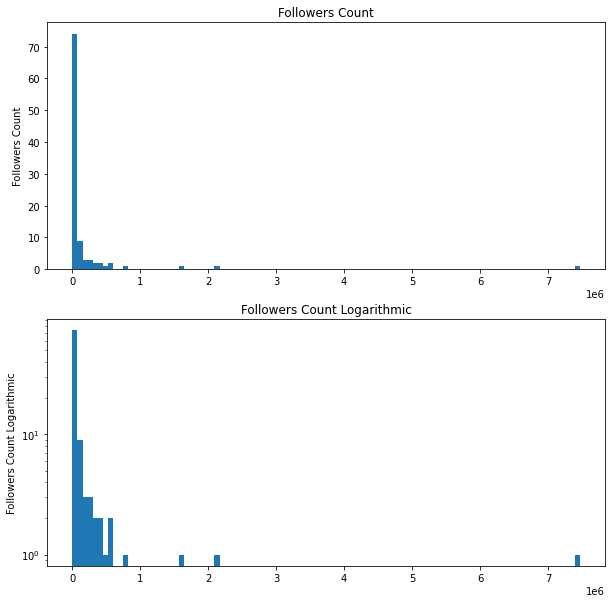

In [10]:
# Your code goes here!

# version with pandas
# # create histogram of follwers count
# follower_social_impact_data.hist(column="public_metrics.followers_count", bins=100)
# # version with log scale
# follower_social_impact_data.hist(column="public_metrics.followers_count", bins=100, log=True)

# version with matplotlib
fig, axes = plt.subplots(2, 1,  figsize=(10,10))
axes[0].hist(follower_social_impact_data["public_metrics.followers_count"], bins=100)
axes[0].set_title("Followers Count")
axes[0].set_ylabel("Followers Count")
# add log scale
axes[1].hist(follower_social_impact_data["public_metrics.followers_count"], bins=100, log=True)
axes[1].set_title("Followers Count Logarithmic")
axes[1].set_ylabel("Followers Count Logarithmic")
fig.show()

## 3.2 Distribution of social impact

Repeat the above task but for the social impact of your users, also look at the logarithmic scale. Again, which one is more skewed?

C:\Users\morit\AppData\Local\Temp/ipykernel_15884/977635605.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


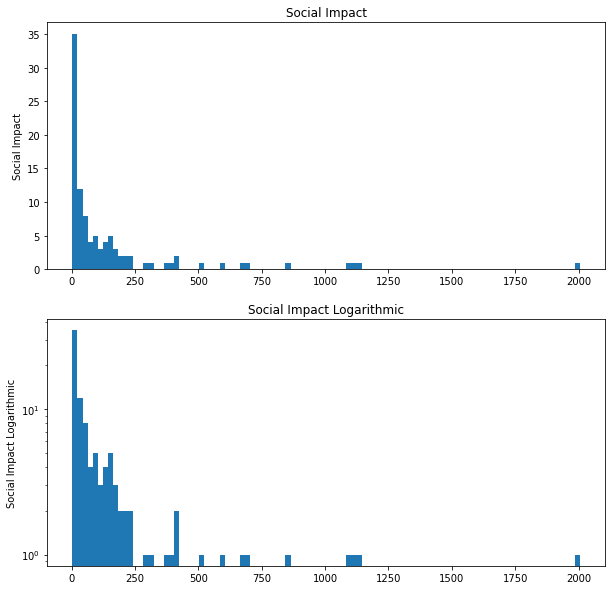

In [11]:
# Your code goes here!

# version with pandas
# # create histogram of follwers count
# follower_social_impact_data.hist(column="public_metrics.retweet_count", bins=100)
# # version with log scale
# follower_social_impact_data.hist(column="public_metrics.retweet_count", bins=100, log=True)

# version with matplotlib
fig, axes = plt.subplots(2, 1,  figsize=(10,10))
axes[0].hist(follower_social_impact_data["public_metrics.retweet_count"], bins=100)
axes[0].set_title("Social Impact")
axes[0].set_ylabel("Social Impact")
# add log scale
axes[1].hist(follower_social_impact_data["public_metrics.retweet_count"], bins=100, log=True)
axes[1].set_title("Social Impact Logarithmic")
axes[1].set_ylabel("Social Impact Logarithmic")
fig.show()

## 3.3 Number of followers vs social impact
Create a scatter plot with the number of followers of each user on the x axis and the social impact of each user on the y axis. Both axis should be in logarithmic scale. Is there a relationship?  

Again you can use pandas [`scatter`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.scatter.html) method with `logx` and `logy` set to true or you can use matplotlibs [`scatter`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html) method. Here you can use the `set_yscale` and `set_xscale` method of the axis to set them to `'log'`.

C:\Users\morit\AppData\Local\Temp/ipykernel_15884/80695605.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


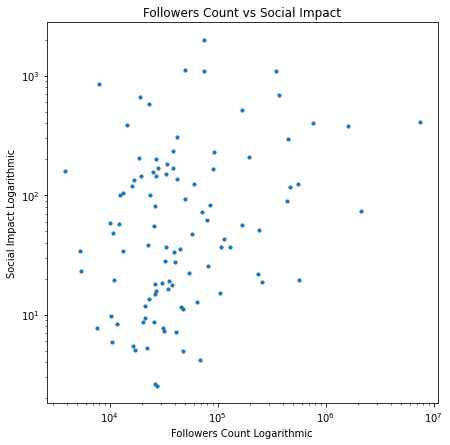

In [12]:
# Your code goes here!

# version with pandas
# follower_social_impact_data.plot.scatter(x="public_metrics.followers_count", y="public_metrics.retweet_count", logx=True, logy=True)

# version with matplotlib
fig, ax = plt.subplots(1, 1,  figsize=(7,7))
ax.scatter(follower_social_impact_data["public_metrics.followers_count"], follower_social_impact_data["public_metrics.retweet_count"], s=10)
ax.set_title("Followers Count vs Social Impact")
ax.set_xlabel("Followers Count Logarithmic")
ax.set_ylabel("Social Impact Logarithmic")
ax.set_yscale('log')
ax.set_xscale('log')
fig.show()

# 4. Fit and visualize a regression model

## 4.1 Fit a linear model

First of all make two new columns on the data frame with the social impact and the follower count. One called `SI` with the logarithm of the amount of retweets, and another called `FC` with the logarithm of the amount of followers. For this you can use numpys log function `np.log(...)`.  

Now fit a linear regression model with sklearn. For this use the class [`LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) to create a linear regression instance and then call the `fit` method. `SI` is used as the dependent variable (target) and `FC` as the independent variable (features).  

Print the model intercept and coefficient. For this you can use the models attributes `coef_` and `intercept_`.

In [13]:
# Your code goes here!
# add logarithmic values of retweet count to the dataframe
follower_social_impact_data["SI"] = follower_social_impact_data["public_metrics.retweet_count"].apply(lambda x: np.log(x))
follower_social_impact_data["FC"] = follower_social_impact_data["public_metrics.followers_count"].apply(lambda x: np.log(x))

In [14]:
# Your code goes here!
# create a linear regression model from the dataframe with SI as the dependent variable and FC as the independent variable
model = LinearRegression().fit(follower_social_impact_data[["FC"]], follower_social_impact_data["SI"])
print(model.coef_, model.intercept_)

[0.33914304] 0.31897341874184715


## 4.2 Plot the results
Now plot the same scatter plot as in 3.3 additional add a line plot which shows the regression line of the model. For this use the intercept and the coefficient (slope). Does the line fit the data as you expected?  

It is easier to use matplotlib here to add the line plot to the scatter plot. For the line plot you can use matplotlibs [`plot`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html) method. For the x values you can use numpy's [`np.linspace`](https://numpy.org/doc/stable/reference/generated/numpy.linspace.html#numpy.linspace) method to evenly space x values in a certain range. The y values can be calculated with the intercept and the slope as follows:  
$
\begin{align}
    y = slope \cdot x + intercept
\end{align}
$

C:\Users\morit\AppData\Local\Temp/ipykernel_15884/2104782362.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


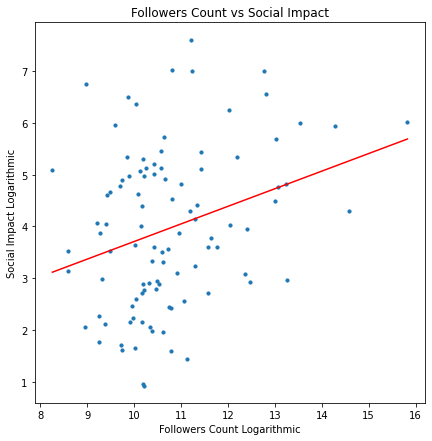

In [15]:
# Your code goes here!
# scatter plot from before add the linear regression line
fig, ax = plt.subplots(1, 1,  figsize=(7,7))
ax.scatter(follower_social_impact_data["FC"], follower_social_impact_data["SI"], s=10)
ax.set_title("Followers Count vs Social Impact")
ax.set_xlabel("Followers Count Logarithmic")
ax.set_ylabel("Social Impact Logarithmic")
# add the linear regression line
x_min = follower_social_impact_data["FC"].min()
x_max = follower_social_impact_data["FC"].max()
# version with predict:
# ax.plot(np.linspace(x_min, x_max, 100), model.predict(np.linspace(x_min, x_max, 100).reshape(-1, 1)), color="red")
# version with intercept and coef:
ax.plot(np.linspace(x_min, x_max, 100), model.intercept_ + model.coef_ * np.linspace(x_min, x_max, 100), color="red")
fig.show()


## 4.3 Calculate quality of the fit
Calculate the residuals of the model and save them in a vector. This can be done with following formula:
$
\begin{align}
residual = y_{true} - y_{pred}
\end{align}
$
where $y_{true}$ are the true values of the dependent variable (in our case `SI`) and $y_{pred}$ are the predicted values with the model. To get the predicted values of the model you can use the [`predict`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) method of the model.  

Afterwards calculate the variance of the residuals and the variance of the social impact variable. For this you can use numpy's [`var`](https://numpy.org/doc/stable/reference/generated/numpy.var.html) function. Is the variance of the residuals lower than the variance of the dependent variable? By how much in proportion?

In [16]:
# Your code goes here!
prediction = model.predict(follower_social_impact_data[["FC"]])
residual = (follower_social_impact_data["SI"] - prediction)
print(np.var(residual))
print(np.var(follower_social_impact_data["SI"]))
print(1 - np.var(residual) / np.var(follower_social_impact_data["SI"]))

2.140787716706327
2.3431785081495757
0.08637446559847373


## 4.4 Distribution of residuals
Plot the histogram of residuals. Do they look normally distributted?  

Again you can use matplotlib as before to plot the histogram.

C:\Users\morit\AppData\Local\Temp/ipykernel_15884/3814693374.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


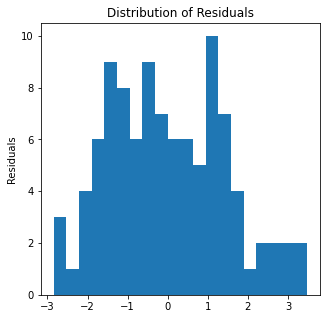

In [17]:
# Your code goes here!
# plot histogram of residuals
fig, ax = plt.subplots(1, 1,  figsize=(5,5))
ax.hist(residual, bins=20)
ax.set_title("Distribution of Residuals")
ax.set_ylabel("Residuals")
fig.show()

# 5. Bootstrapping

## 5.1 One sample
For bootsrapping we first look at creating one sample. For this use the follower and social impact dataframe from before and sample random rows with replacement. This again can be done with pandas [`sample`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html) method and the keyword argument `replace` set to `True`.  

Fit a new linear regression model with this new dataset. What is the value of the coefficient and the intercept now?

In [18]:
# Your code goes here!
sampled_users = follower_social_impact_data.sample(100, replace=True)
single_sample_bs_model = LinearRegression()
single_sample_bs_model.fit(sampled_users[["FC"]], sampled_users["SI"])
print(single_sample_bs_model.coef_, single_sample_bs_model.intercept_)

[0.39661643] -0.032143242099636815


## 5.2 Many bootstrap samples
Now repeat this 10000 times, save the resulting coefficient in a vector.

In [19]:
# Your code goes here!
multi_sample_bs_model_coef = []
for i in range(10000):
    boot = follower_social_impact_data.sample(100, replace=True)
    multi_sample_bs_model = LinearRegression()
    multi_sample_bs_model.fit(boot[["FC"]], boot["SI"])
    multi_sample_bs_model_coef.append(multi_sample_bs_model.coef_)
multi_sample_bs_model_coef = np.array(multi_sample_bs_model_coef)

## 5.3 Bootstrap histogram

Plot a histogram of the values resulting from the permutations and add a vertical line on the value of the coefficient of the original model (from task 4.1). For adding a vertical line to the histogram in matplotlib you can use the [`axvline`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.axvline.html) method.  

 How far is the line from the center of the histogram?

C:\Users\morit\AppData\Local\Temp/ipykernel_15884/3857470839.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


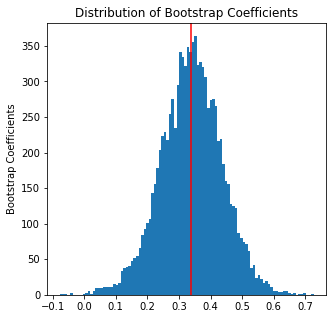

In [20]:
# Your code goes here!
# plot histogram of bootstrap coefficients
fig, ax = plt.subplots(1, 1,  figsize=(5,5))
ax.hist(multi_sample_bs_model_coef, bins=100)
ax.set_title("Distribution of Bootstrap Coefficients")
ax.set_ylabel("Bootstrap Coefficients")
# add vertical at original model coef
ax.axvline(model.coef_, color="red")
fig.show()